In [1]:
from keras.layers import Input, Convolution2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import SGD
import numpy.random as rng
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Convolution2D(64,10,10,activation='relu',input_shape=input_shape,init=W_init))
convnet.add(MaxPooling2D())
convnet.add(Convolution2D(128,7,7,activation='relu',init=W_init))
convnet.add(MaxPooling2D())
convnet.add(Convolution2D(128,4,4,activation='relu',init=W_init))
convnet.add(MaxPooling2D())
convnet.add(Convolution2D(256,4,4,activation='relu',init=W_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid"))
#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#merge two encoded inputs with the l1 distance between them
L1_distance = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
prediction = Dense(1,activation='sigmoid')(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)
optimizer = SGD(0.001,momentum=0.5,nesterov=True,decay=0.0003)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

Using TensorFlow backend.


In [2]:
with open( "/home/soren/keras-oneshot/train.pickle","r") as f:
    (X,y,c) = pickle.load(f)

with open( "/home/soren/keras-oneshot/val.pickle","r") as f:
    (Xval,yval,cval) = pickle.load(f)
print(X.shape)
a=siamese_net.predict([X[1,1,:,:].reshape(1,105,105,1),X[7,1,:,:].reshape(1,105,105,1) ])
b=siamese_net.predict([X[7,1,:,:].reshape(1,105,105,1),X[1,1,:,:].reshape(1,105,105,1) ])


(964, 20, 105, 105)


In [3]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self,Xtrain,Xval):
        
        self.Xval = Xval# / Xval.max()
        self.Xtrain = Xtrain# / Xtrain.max()


        self.n_classes,self.n_examples,self.w,self.h = Xtrain.shape
        self.n_val,self.n_ex_val,_,_ = Xval.shape

    def get_batch(self,n):
        """Create batch of n pairs, half same class, half different class"""
        categories = rng.choice(self.n_classes,size=(n,),replace=False)
        pairs=[np.zeros((n, self.h, self.w,1)) for i in range(2)]
        targets=np.zeros((n,))
        targets[n//2:] = 1
        for i in range(n):
            category = categories[i]
            idx_1 = rng.randint(0,self.n_examples)
            pairs[0][i,:,:,:] = self.Xtrain[category,idx_1].reshape(self.w,self.h,1)
            idx_2 = rng.randint(0,self.n_examples)
            #pick images of same class for 1st half, different for 2nd
            category_2 = category if i >= n//2 else (category + rng.randint(1,self.n_classes)) % self.n_classes
            pairs[1][i,:,:,:] = self.Xtrain[category_2,idx_2].reshape(self.w,self.h,1)
        return pairs, targets

    def make_oneshot_task(self,N):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        categories = rng.choice(self.n_val,size=(N,),replace=False)
        indices = rng.randint(0,self.n_ex_val,size=(N,))
        true_category = categories[0]
        ex1, ex2 = rng.choice(self.n_examples,replace=False,size=(2,))
        test_image = np.asarray([self.Xval[true_category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        support_set = self.Xval[categories,indices,:,:]
        support_set[0,:,:] = self.Xval[true_category,ex2]
        support_set = support_set.reshape(N,self.w,self.h,1)
        pairs = [test_image,support_set]
        targets = np.zeros((N,))
        targets[0] = 1
        return pairs, targets
    
    def test_oneshot(self,model,N,k,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        pass
        n_correct = 0
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N)
            probs = model.predict(inputs)
            if np.argmax(probs) == 0:
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    


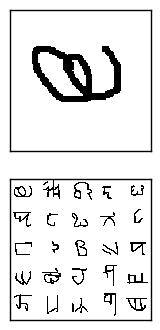

In [4]:
loader = Siamese_Loader(X,Xval)

def concat_images(X):
    """Concatenates a bnch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(25)
plot_oneshot_task(pairs)


In [ ]:
evaluate_every = 250
loss_every=40
batch_size = 128
N_way = 20
n_val = 60
siamese_net.load_weights("/home/soren/keras-oneshot/weights")
for i in range(90000):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
    if i % loss_every == 0:
        print("iteration {}, training loss: {},".format(i,loss))

        


Evaluating model on 60 unique 20 way one-shot learning tasks ...
Got an average of 43.3333333333% 20 way one-shot learning accuracy
iteration 0, training loss: 0.400377213955,
iteration 40, training loss: 0.360177010298,
iteration 80, training loss: 0.359253257513,
iteration 120, training loss: 0.352402210236,
iteration 160, training loss: 0.34878513217,
iteration 200, training loss: 0.342484951019,


In [7]:
siamese_net.save('/home/soren/keras-oneshot/weights')
        
    